In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
import string
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter

import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus']=False

path = 'c:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font',family=font_name)

In [2]:
gg_ic = pd.read_csv('df_one_four')

In [ ]:
gg_ic.head(3)

In [ ]:
df_sr = pd.DataFrame(gg_ic[gg_ic['region']=='경기']['star&reviews'])
df_sr.head(3)

In [ ]:
# 긍정 / 부정 나누기

good_list = []
bad_list= []
# 각 행에 대해 반복
for i in range(len(df_sr)):
    list = eval(df_sr['star&reviews'][i])
    for hotel in range(len(list)):
            # 'star&reviews' 열의 값을 평가하고 리스트로 변환
            reviews_list = list[hotel]
            if reviews_list[0] >= 4:
                good_list.append(reviews_list[2])
            elif  reviews_list[0] <=2.5:
                bad_list.append(reviews_list[2])

print(f'good:{good_list[0]}\nbad:{bad_list[0]}')

In [ ]:
good_list_join = ' '.join(good_list)
bad_list_join = ' '.join(bad_list)

# 특수기호 지우기(string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
def remove_punctuation(text):
    return ''.join([i for i in text if i not in string.punctuation])
    
good_list_join = remove_punctuation(good_list_join)
bad_list_join = remove_punctuation(bad_list_join)

good_list_join =good_list_join.replace('\n', '').replace(' ', '')
bad_list_join = bad_list_join.replace('\n', '').replace(' ', '')

In [ ]:
good_list_join

In [ ]:
# 불용어 / '호텔'이란 단어도 너무 많이 나와 불용어에 추가

stopwords_kr = pd.read_csv('한국어 불용어 리스트.csv', encoding='CP949', sep='\t')
stopwords_kr.loc[len(stopwords_kr)] = '호텔'

In [ ]:
# 단어 토큰화
okt = Okt()
word_tokens_good = okt.pos(good_list_join)
word_tokens_bad = okt.pos(bad_list_join)

In [ ]:
# 불용어 제거 / tag이용해서 'Noun'만 추출가능
token_rv_good = [word for word, tag in word_tokens_good if len(word) > 1 if word not in stopwords_kr]
token_rv_bad = [word for word, tag in word_tokens_bad if len(word) > 1 if word not in stopwords_kr]

In [ ]:
freq_good = pd.DataFrame(pd.Series(Counter(token_rv_good)).sort_values(ascending=False), columns=['freq'])
freq_bad = pd.DataFrame(pd.Series(Counter(token_rv_bad)).sort_values(ascending=False), columns=['freq'])

In [ ]:
good_list_join = ' '.join(token_rv_good)
bad_list_join = ' '.join(token_rv_bad)

In [ ]:
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 긍정 워드클라우드
wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(good_list_join)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(f"긍정 키워드", fontsize=16)
plt.show()

In [ ]:
gg_ic['star'] = ''
gg_ic['reviews'] = ''

In [ ]:
# 각 호텔마다 별점만 따로 column 만들기
stars_list = []

# 각 행에 대해 반복
for i in range(len(gg_ic)):
    list = eval(gg_ic['star&reviews'][i])
    for hotel in range(len(list)):
            # 'star&reviews' 열의 값을 평가하고 리스트로 변환
            reviews_list = list[hotel]
            stars_list.append(str(reviews_list[0]))

count = 0
for i in range(len(gg_ic)):
    subset_of_stars_list = stars_list[count:50 + count]
    gg_ic['star'].loc[i] = subset_of_stars_list
    count += 50

# 각 호텔마다 리뷰만 따로 column 만들기
reviews_list = []

# 각 행에 대해 반복
for i in range(len(gg_ic)):
    list = eval(gg_ic['star&reviews'][i])
    for hotel in range(len(list)):
            # 'star&reviews' 열의 값을 평가하고 리스트로 변환
            review_list = list[hotel]
            reviews_list.append(review_list[2])

count = 0
for i in range(len(gg_ic)):
    subset_of_reviews_list = reviews_list[count:50 + count]
    gg_ic['reviews'].loc[i] = subset_of_reviews_list
    count += 50

In [ ]:
gg_ic.head(3)

In [ ]:
gg_ic.info()

In [ ]:
# 각 행에 대해 반복하여 구두점을 제거하는 함수 적용
for i in range(len(gg_ic)):
    gg_ic['reviews'].loc[i] = remove_punctuation(gg_ic['reviews'][i])

In [ ]:
# # 전국 합쳐서 사용할 떄
# font_path = 'C:/Windows/Fonts/malgun.ttf'
# wordcloud = WordCloud(width = 600, height = 600, max_words=20000,font_path = font_path, background_color='white').generate(str(all_word))
# plt.figure(figsize=(20, 10))
# plt.imshow(wordcloud)
# plt.axis('off')

In [ ]:
# word_tokens.unqiue()

In [ ]:
# # 가격 = 가성비 처럼 같은 뜻을 같고 있는 단어들을 통일 시키기
# # good
# word_tokens_good = ["가성비" if word == "가격" else word for word in word_tokens]

# # bad
# word_tokens_bad = ["비싸다" if word == "가격" else word for word in word_tokens]

In [3]:
def goodbad_wordcloud(df, region): 

    df_sr = pd.DataFrame(df[df['region']==region]['star&reviews'])
    good_list = []
    bad_list= []
    # 각 행에 대해 반복
    for i in range(len(df_sr)):
        list = eval(df_sr['star&reviews'][i])
        for hotel in range(len(list)):
                # 'star&reviews' 열의 값을 평가하고 리스트로 변환
                reviews_list = list[hotel]
                if reviews_list[0] >= 4:
                    good_list.append(reviews_list[2])
                elif  reviews_list[0] <=2.5:
                    bad_list.append(reviews_list[2])

    # good / bad 별 review 합치기
    good_list_join = ' '.join(good_list)
    bad_list_join = ' '.join(bad_list)
    
    # 특수기호 지우기(string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    def remove_punctuation(text):
        return ''.join([i for i in text if i not in string.punctuation])
    good_list_join =good_list_join.replace('\n', '').replace(' ', '')
    bad_list_join = bad_list_join.replace('\n', '').replace(' ', '')
        
    good_list_join = remove_punctuation(good_list_join)
    bad_list_join = remove_punctuation(bad_list_join)
    
    # 불용어 / '호텔'이란 단어도 너무 많이 나와 불용어에 추가
    stopwords_kr = pd.read_csv('한국어 불용어 리스트.csv', encoding='CP949', sep='\t')
    stopwords_kr.loc[len(stopwords_kr)] = '호텔'

    # 단어 토큰화
    okt = Okt()
    word_tokens_good = okt.pos(good_list_join)
    word_tokens_bad = okt.pos(bad_list_join)
    
    # 불용어 제거 / tag이용해서 'Noun'만 추출가능
    token_rv_good = [word for word, tag in word_tokens_good if len(word) > 1 if word not in stopwords_kr]
    token_rv_bad = [word for word, tag in word_tokens_bad if len(word) > 1 if word not in stopwords_kr]
    freq_good = pd.DataFrame(pd.Series(Counter(token_rv_good)).sort_values(ascending=False), columns=['freq'])
    freq_bad = pd.DataFrame(pd.Series(Counter(token_rv_bad)).sort_values(ascending=False), columns=['freq'])

    good_list_join = ' '.join(token_rv_good)
    bad_list_join = ' '.join(token_rv_bad)

    font_path = 'C:/Windows/Fonts/malgun.ttf'
    
    # 긍정 워드클라우드
    wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(good_list_join)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"{region}의 긍정 키워드", fontsize=16)
    plt.show()
    
    # 부정 워드클라우드
    wordcloud = WordCloud(width = 600, height = 600, max_words=20000, font_path = font_path, background_color='white').generate(bad_list_join)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"{region}의 부정 키워드", fontsize=16)
    plt.show()
    
    return freq_good, freq_bad

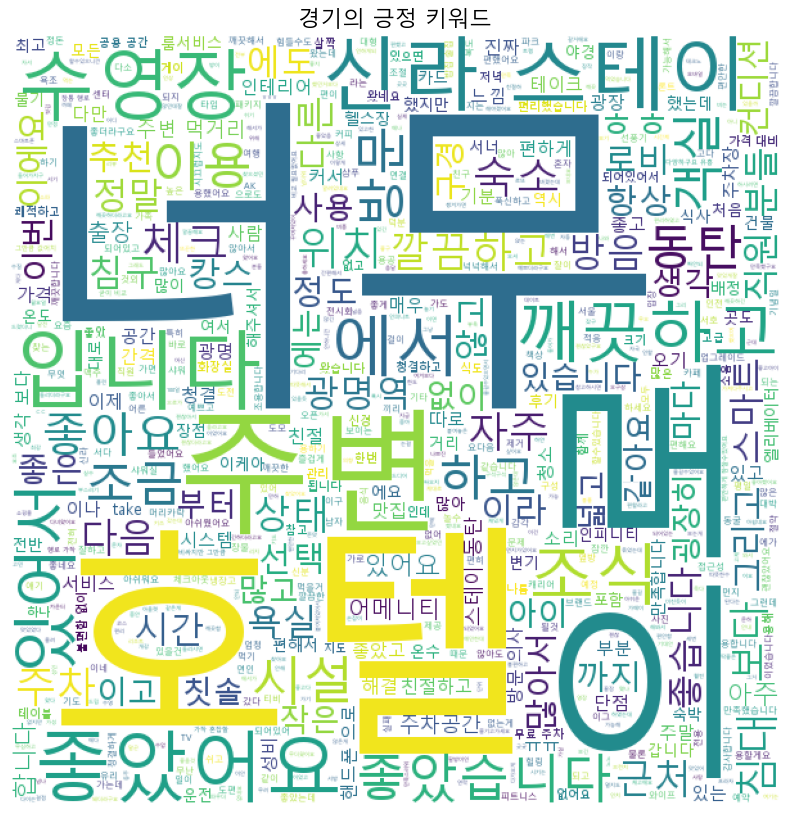

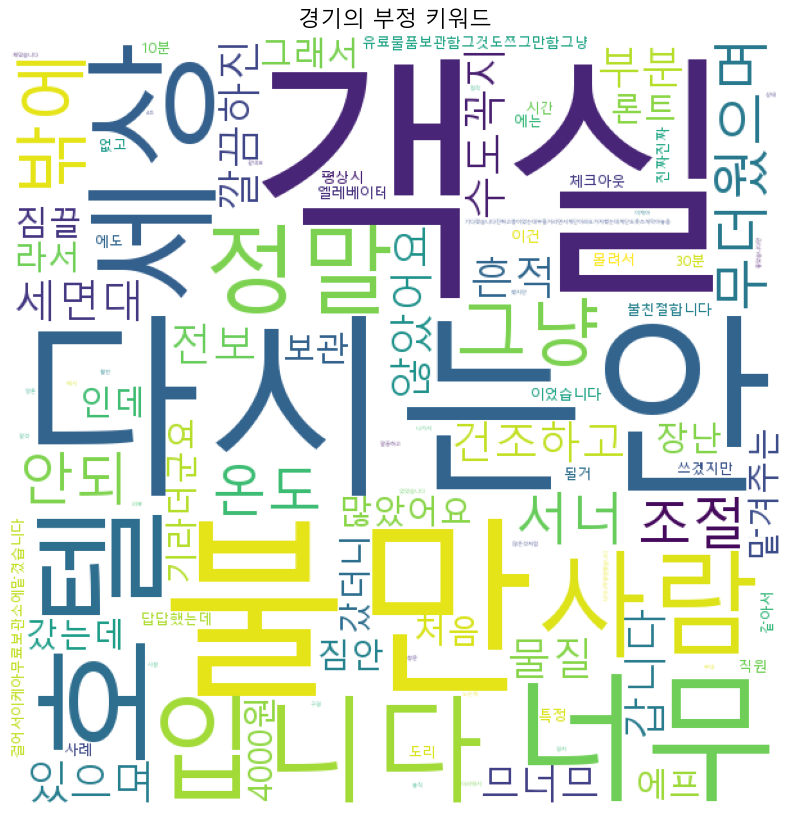

In [4]:
good, bad = goodbad_wordcloud(gg_ic,'경기')

In [5]:
good

,freq
너무,46
호텔,24
으로,23
주변,21
스테이,17
...,...
본인,1
신용카드,1
꽂아,1
서사,1


In [6]:
bad

,freq
객실,2
다시는안,2
정말,2
사람,2
입니다,2
...,...
갔는데,1
짐끌,1
라서,1
론트,1
